In [102]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [103]:
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using {device}")

epochs = 100
batch_size = 128
lr = 2e-4
betas = (0.5, 0.999)

Using cuda


# Deep Convolutional GAN (DCGAN)

# Generator

We will just make G fully convolutional, also increasing its trainable parameters. We'll use 2D Transposed Convolutional layers to do so:

In [126]:
class Generator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()

        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape

        channels = [self.noise_dim, 512, 256, 128, 64, 1]
        kernel_sizes = [4, 4, 3, 3, 4]
        strides = [1, 2, 2, 2, 1]
        paddings = [0, 1, 1, 1, 2]
        activations = [nn.PReLU() for _ in channels[1:]]
        activations.append(nn.Tanh())

        layers = []
        for i in range(len(channels) - 1):
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=channels[i],
                    out_channels=channels[i+1],
                    kernel_size=kernel_sizes[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False
                )
            )
            if i < len(channels) - 2:  # No batch norm or activation after the last Conv layer
                layers.append(nn.BatchNorm2d(num_features=channels[i+1]))
                layers.append(activations[i])

        self.generator = nn.Sequential(*layers)

    def forward(self, noise):
        noise = noise.view(-1, self.noise_dim, 1, 1)
        return self.generator(noise).view(-1, *self.data_shape)

# Discriminator

Likewise for D:

In [127]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()

        self.data_shape = input_shape

        # Layer specifications
        channels = [1, 64, 128, 256, 512, 1]
        kernel_sizes = [4, 3, 3, 4, 4]
        strides = [1, 2, 2, 2, 2]
        paddings = [2, 1, 1, 1, 0]
        use_batch_norm = [False, True, True, True, False]

        layers = []
        for i in range(len(channels) - 1):
            layers.append(
                nn.Conv2d(
                    in_channels=channels[i],
                    out_channels=channels[i+1],
                    kernel_size=kernel_sizes[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False
                )
            )
            if use_batch_norm[i]:
                layers.append(nn.BatchNorm2d(num_features=channels[i+1]))
            layers.append(nn.PReLU())

        # Combine all layers into a sequential model
        self.discriminator = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x).view(-1, 1)

In [128]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [129]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

data_shape = (1, 28, 28)
noise_dim = 100

In [130]:
gen = Generator(input_shape=data_shape, noise_shape=noise_dim,).to(device)
gen.apply(weights_init)
gen(tc.zeros(size=(batch_size, noise_dim), device=device))
opt_gen = Adam(params=gen.parameters(), lr=lr, betas=betas)
_ = summary(model=gen, input_data=tc.zeros(size=(batch_size, noise_dim)))

torch.Size([12, 100])
torch.Size([12, 1, 28, 28])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─PReLU: 2-3                        [-1, 512, 4, 4]           1
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─PReLU: 2-6                        [-1, 256, 8, 8]           1
|    └─ConvTranspose2d: 2-7              [-1, 128, 15, 15]         294,912
|    └─BatchNorm2d: 2-8                  [-1, 128, 15, 15]         256
|    └─PReLU: 2-9                        [-1, 128, 15, 15]         1
|    └─ConvTranspose2d: 2-10             [-1, 64, 29, 29]          73,728
|    └─BatchNorm2d: 2-11                 [-1, 64, 29, 29]          128
|    └─PReL

In [109]:
disc = Discriminator(input_shape=data_shape).to(device)
disc.apply(weights_init)
opt_disc = Adam(params=disc.parameters(), lr=lr, betas=betas)
_ = summary(model=disc, input_data=tc.zeros(size=(batch_size, np.prod(data_shape))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 29, 29]          1,024
|    └─PReLU: 2-2                        [-1, 64, 29, 29]          1
|    └─Conv2d: 2-3                       [-1, 128, 15, 15]         73,728
|    └─BatchNorm2d: 2-4                  [-1, 128, 15, 15]         256
|    └─PReLU: 2-5                        [-1, 128, 15, 15]         1
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           294,912
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─PReLU: 2-8                        [-1, 256, 8, 8]           1
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─PReLU: 2-11                       [-1, 512, 4, 4]           1
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]           

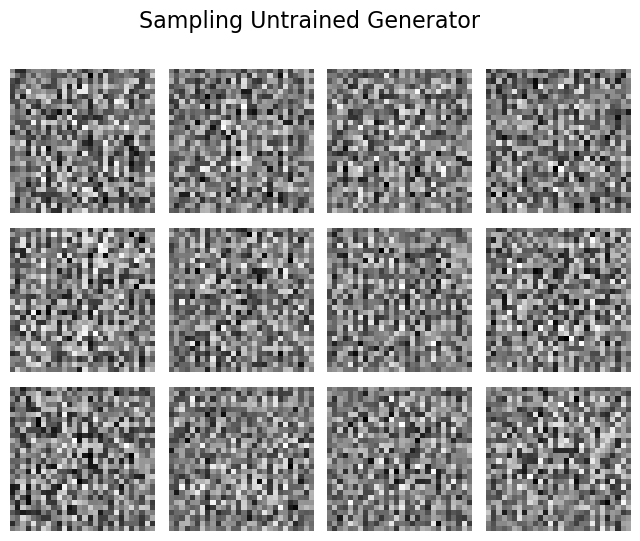

In [132]:
def generate(n_samples, title):
    # Inference:
    z = tc.randn(n_samples, noise_dim, device=device)
    x_hat = gen(z).detach().cpu().numpy().reshape(-1, 28, 28)

    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

no_samples = 12
generate(no_samples, title="Sampling Untrained Generator")

100%|██████████| 469/469 [00:55<00:00,  8.45it/s]


Epoch [1/100] | Loss D: 0.3160 | Loss G: 3.5583


100%|██████████| 469/469 [00:54<00:00,  8.66it/s]


Epoch [2/100] | Loss D: 0.3297 | Loss G: 2.4100


100%|██████████| 469/469 [00:54<00:00,  8.62it/s]


Epoch [3/100] | Loss D: 0.3069 | Loss G: 2.2786


100%|██████████| 469/469 [00:54<00:00,  8.56it/s]


Epoch [4/100] | Loss D: 0.3041 | Loss G: 2.2522


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch [5/100] | Loss D: 0.3037 | Loss G: 2.2804


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch [6/100] | Loss D: 0.2932 | Loss G: 2.2799


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch [7/100] | Loss D: 0.2664 | Loss G: 2.4096


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch [8/100] | Loss D: 0.2772 | Loss G: 2.4217


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [9/100] | Loss D: 0.2338 | Loss G: 2.5818


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [10/100] | Loss D: 0.2255 | Loss G: 2.6434


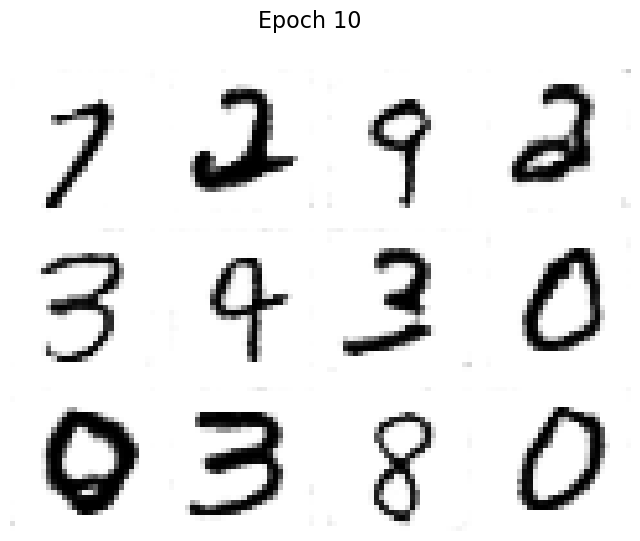

100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [11/100] | Loss D: 0.2154 | Loss G: 2.7719


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [12/100] | Loss D: 0.1901 | Loss G: 2.9584


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [13/100] | Loss D: 0.1965 | Loss G: 2.9138


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [14/100] | Loss D: 0.1975 | Loss G: 3.0439


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [15/100] | Loss D: 0.1960 | Loss G: 3.0427


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [16/100] | Loss D: 0.1798 | Loss G: 3.1233


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [17/100] | Loss D: 0.1852 | Loss G: 3.1341


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [18/100] | Loss D: 0.1701 | Loss G: 3.2685


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch [19/100] | Loss D: 0.1598 | Loss G: 3.4186


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch [20/100] | Loss D: 0.1592 | Loss G: 3.3578


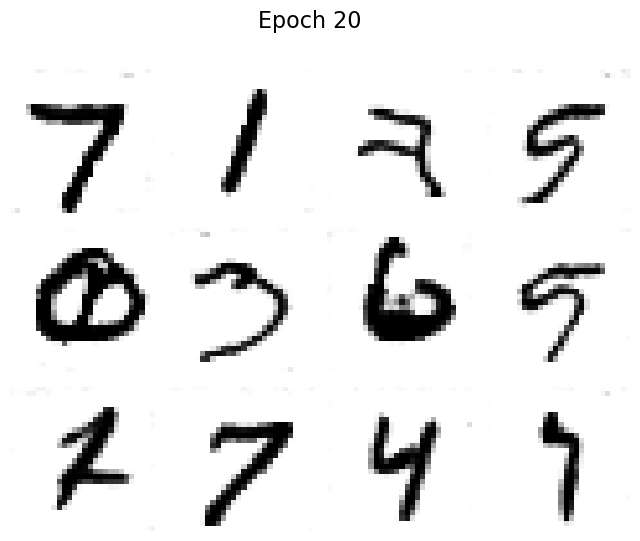

100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch [21/100] | Loss D: 0.1549 | Loss G: 3.2595


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [22/100] | Loss D: 0.1444 | Loss G: 3.4862


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [23/100] | Loss D: 0.1179 | Loss G: 3.6773


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [24/100] | Loss D: 0.1599 | Loss G: 3.5124


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [25/100] | Loss D: 0.1239 | Loss G: 3.5690


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [26/100] | Loss D: 0.1487 | Loss G: 3.8231


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [27/100] | Loss D: 0.1941 | Loss G: 3.1973


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [28/100] | Loss D: 0.1541 | Loss G: 3.5607


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [29/100] | Loss D: 0.1602 | Loss G: 3.5552


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [30/100] | Loss D: 0.1012 | Loss G: 3.7401


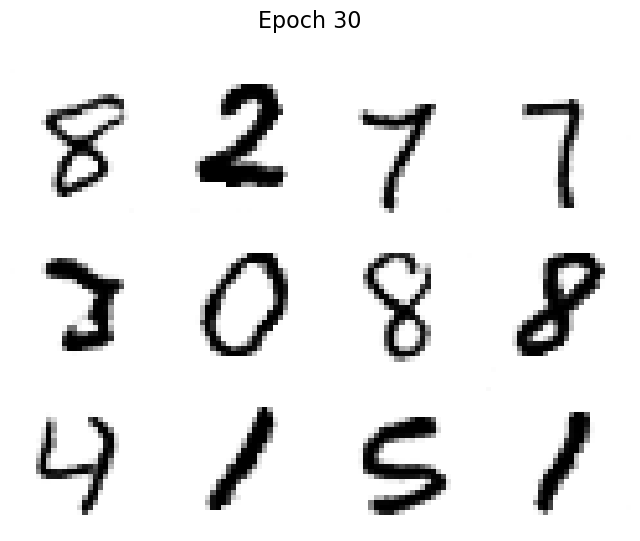

100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [31/100] | Loss D: 0.1345 | Loss G: 3.9906


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [32/100] | Loss D: 0.0961 | Loss G: 4.0705


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [33/100] | Loss D: 0.0921 | Loss G: 4.0700


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [34/100] | Loss D: 0.1292 | Loss G: 3.9424


100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Epoch [35/100] | Loss D: 0.1126 | Loss G: 4.0826


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [36/100] | Loss D: 0.0616 | Loss G: 4.4609


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [37/100] | Loss D: 0.1830 | Loss G: 3.7989


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [38/100] | Loss D: 0.0693 | Loss G: 4.3670


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [39/100] | Loss D: 0.1235 | Loss G: 4.4584


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [40/100] | Loss D: 0.0915 | Loss G: 4.1234


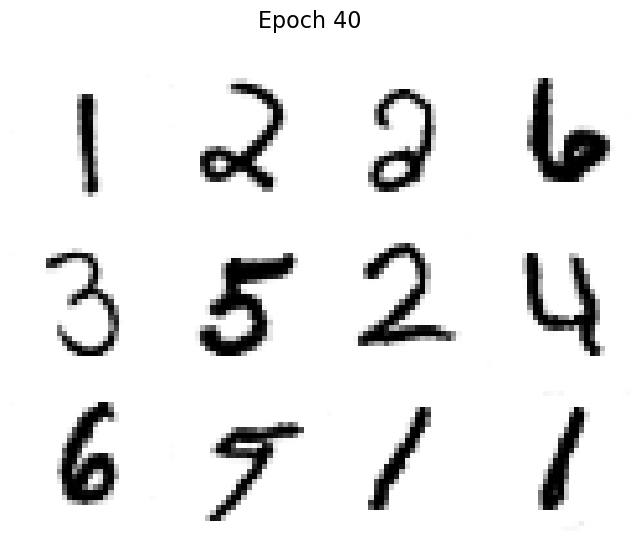

100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [41/100] | Loss D: 0.0603 | Loss G: 4.6958


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [42/100] | Loss D: 0.1203 | Loss G: 4.2489


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [43/100] | Loss D: 0.0383 | Loss G: 4.9546


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [44/100] | Loss D: 0.1119 | Loss G: 4.4541


100%|██████████| 469/469 [00:56<00:00,  8.25it/s]


Epoch [45/100] | Loss D: 0.0688 | Loss G: 4.9139


100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Epoch [46/100] | Loss D: 0.0841 | Loss G: 4.5642


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [47/100] | Loss D: 0.1296 | Loss G: 4.6120


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [48/100] | Loss D: 0.0882 | Loss G: 4.4043


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [49/100] | Loss D: 0.0297 | Loss G: 5.2502


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [50/100] | Loss D: 0.0843 | Loss G: 4.8776


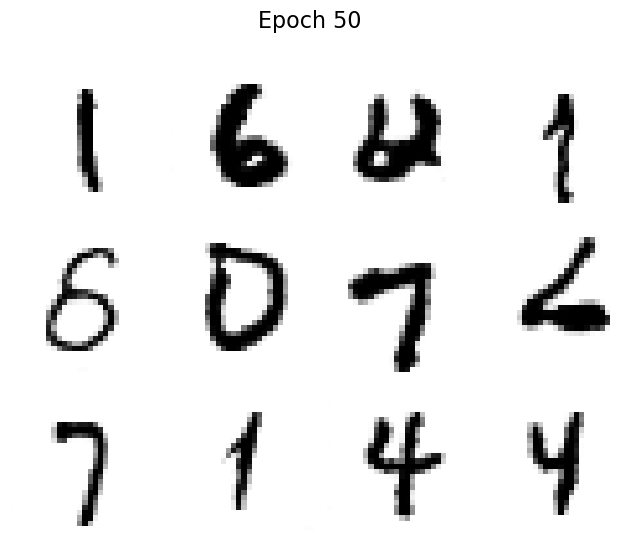

100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [51/100] | Loss D: 0.0891 | Loss G: 4.8608


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [52/100] | Loss D: 0.0750 | Loss G: 4.9833


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [53/100] | Loss D: 0.0781 | Loss G: 4.8464


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [54/100] | Loss D: 0.0432 | Loss G: 5.2901


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [55/100] | Loss D: 0.1155 | Loss G: 4.8166


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [56/100] | Loss D: 0.0745 | Loss G: 5.0068


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [57/100] | Loss D: 0.0634 | Loss G: 5.1404


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [58/100] | Loss D: 0.0777 | Loss G: 5.2611


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [59/100] | Loss D: 0.0789 | Loss G: 4.7741


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [60/100] | Loss D: 0.0203 | Loss G: 5.8366


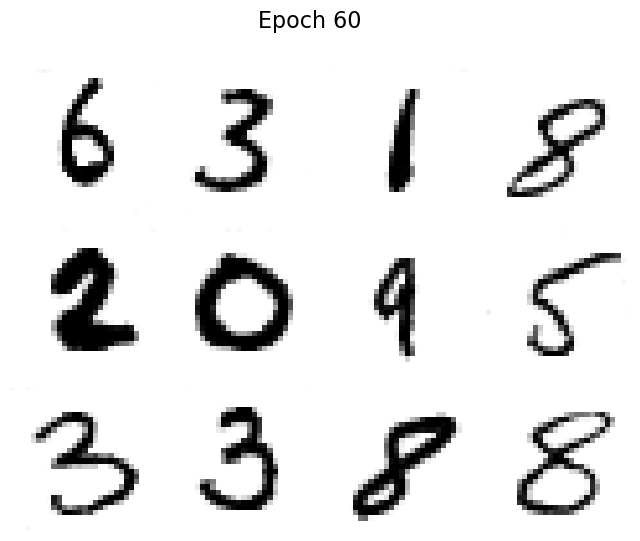

100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [61/100] | Loss D: 0.1297 | Loss G: 4.7523


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [62/100] | Loss D: 0.0379 | Loss G: 5.2844


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [63/100] | Loss D: 0.0609 | Loss G: 5.5701


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch [64/100] | Loss D: 0.0323 | Loss G: 5.6391


100%|██████████| 469/469 [00:55<00:00,  8.40it/s]


Epoch [65/100] | Loss D: 0.0975 | Loss G: 5.1009


100%|██████████| 469/469 [00:55<00:00,  8.43it/s]


Epoch [66/100] | Loss D: 0.0159 | Loss G: 6.0338


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch [67/100] | Loss D: 0.1068 | Loss G: 5.2160


100%|██████████| 469/469 [00:55<00:00,  8.45it/s]


Epoch [68/100] | Loss D: 0.0519 | Loss G: 5.4525


100%|██████████| 469/469 [00:55<00:00,  8.46it/s]


Epoch [69/100] | Loss D: 0.0398 | Loss G: 5.6391


100%|██████████| 469/469 [00:55<00:00,  8.47it/s]


Epoch [70/100] | Loss D: 0.0899 | Loss G: 5.6280


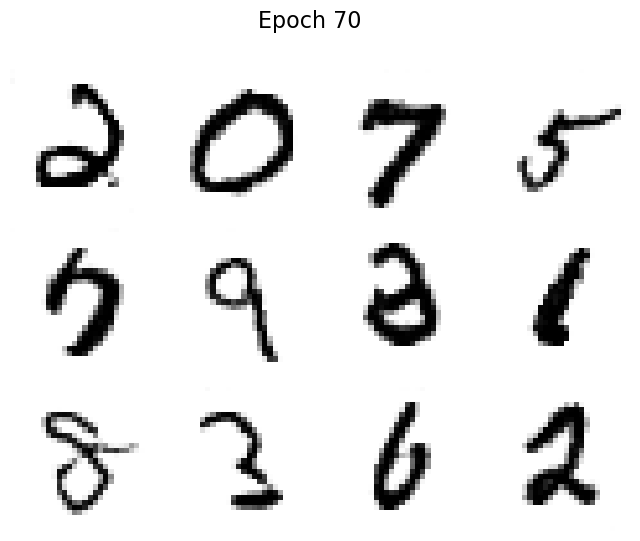

100%|██████████| 469/469 [00:55<00:00,  8.45it/s]


Epoch [71/100] | Loss D: 0.0273 | Loss G: 5.8758


100%|██████████| 469/469 [00:55<00:00,  8.42it/s]


Epoch [72/100] | Loss D: 0.1367 | Loss G: 6.4797


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [73/100] | Loss D: 0.1304 | Loss G: 4.6168


100%|██████████| 469/469 [00:55<00:00,  8.45it/s]


Epoch [74/100] | Loss D: 0.0340 | Loss G: 5.7279


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [75/100] | Loss D: 0.0504 | Loss G: 6.0586


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch [76/100] | Loss D: 0.0402 | Loss G: 5.6279


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [77/100] | Loss D: 0.0417 | Loss G: 6.0547


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [78/100] | Loss D: 0.0765 | Loss G: 5.7117


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch [79/100] | Loss D: 0.0451 | Loss G: 5.8752


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch [80/100] | Loss D: 0.0741 | Loss G: 5.4715


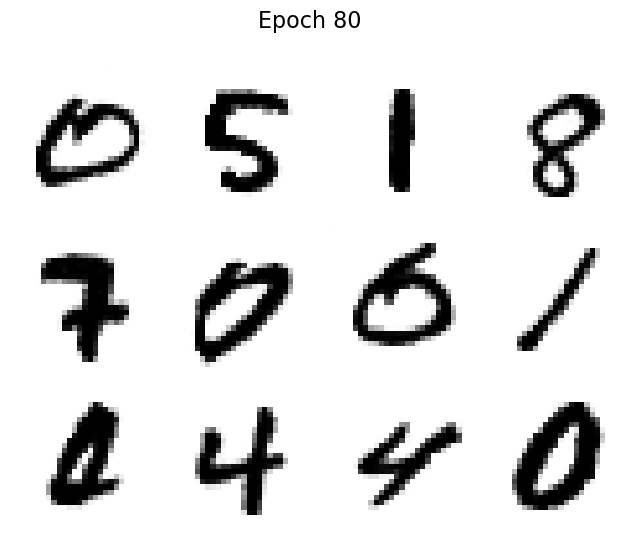

100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [81/100] | Loss D: 0.0120 | Loss G: 6.5315


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [82/100] | Loss D: 0.0600 | Loss G: 6.9351


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch [83/100] | Loss D: 0.0715 | Loss G: 5.3088


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch [84/100] | Loss D: 0.0114 | Loss G: 6.6722


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [85/100] | Loss D: 0.0872 | Loss G: 5.7649


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [86/100] | Loss D: 0.0578 | Loss G: 6.4246


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch [87/100] | Loss D: 0.0509 | Loss G: 5.7056


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [88/100] | Loss D: 0.0693 | Loss G: 5.8304


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch [89/100] | Loss D: 0.0165 | Loss G: 6.3748


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch [90/100] | Loss D: 0.0081 | Loss G: 7.1904


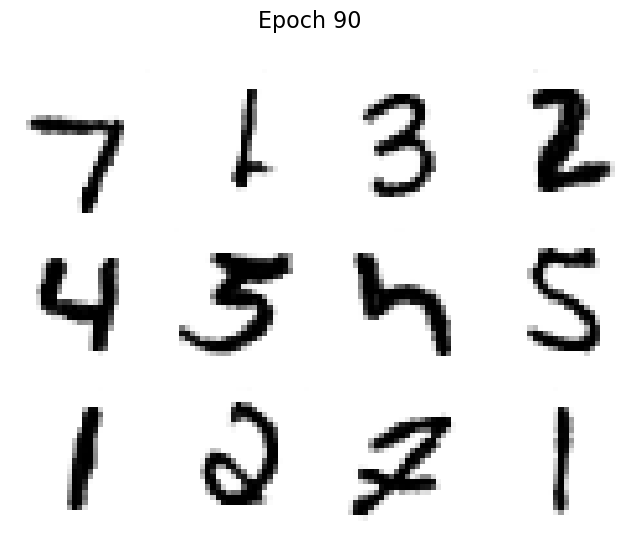

100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [91/100] | Loss D: 0.0957 | Loss G: 5.9339


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [92/100] | Loss D: 0.0856 | Loss G: 5.0388


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch [93/100] | Loss D: 0.0145 | Loss G: 6.4525


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch [94/100] | Loss D: 0.0075 | Loss G: 7.1878


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch [95/100] | Loss D: 0.0100 | Loss G: 7.3759


100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


Epoch [96/100] | Loss D: 0.0059 | Loss G: 7.6016


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


Epoch [97/100] | Loss D: 0.1720 | Loss G: 5.2210


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch [98/100] | Loss D: 0.0199 | Loss G: 6.2840


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch [99/100] | Loss D: 0.0100 | Loss G: 7.1682


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch [100/100] | Loss D: 0.0704 | Loss G: 6.8624


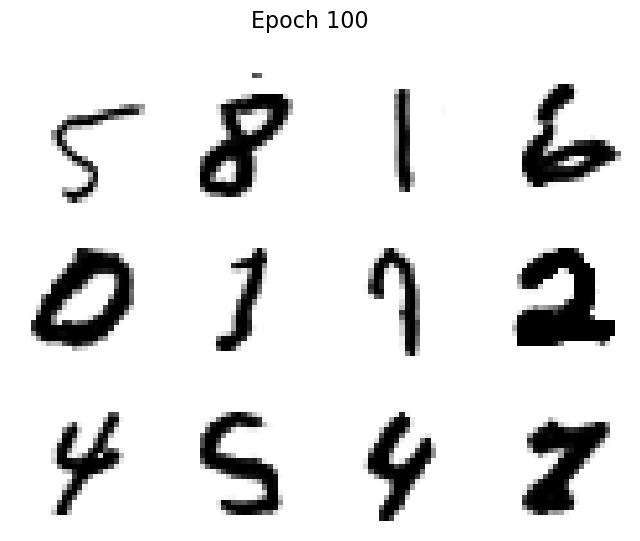

In [133]:
def train_loop():

    loss_fn = nn.BCELoss()

    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    sample_every = 10
    gen.train()
    disc.train()

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            opt_disc.zero_grad()
            x = x.to(device)
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            target_fake = tc.zeros((x.shape[0], 1)).to(device)
            pred_real = disc(x)
            pred_fake = disc(x_hat)

            loss_real = loss_fn(pred_real, target_real)
            loss_fake = loss_fn(pred_fake, target_fake)
            loss_disc = (loss_real + loss_fake) / 2
            disc_loss += loss_disc.item()

            loss_disc.backward()
            opt_disc.step()

            # ------------------------ Train Generator: ------------------------
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            pred_fake = disc(x_hat)

            loss_gen = loss_fn(pred_fake, target_real)
            gen_loss += loss_gen.item()

            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(no_samples, f"Epoch {epoch + 1}")
            gen.train()

    return disc_losses, gen_losses

d_loss, g_loss = train_loop()

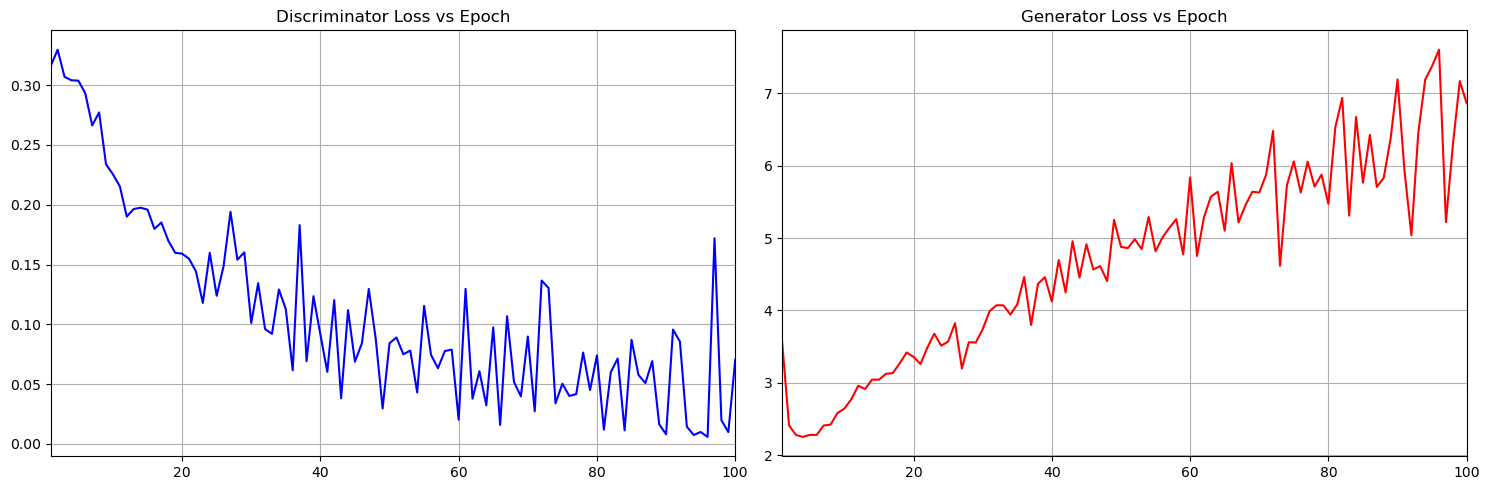

In [134]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epoch_ax, d_loss, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("Discriminator Loss vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, g_loss, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("Generator Loss vs Epoch")
ax[1].grid()

plt.tight_layout()
plt.show()
plt.close()